In [52]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pdb
from mpl_toolkits.mplot3d import Axes3D

In [ ]:

class RBFKernel2D(nn.Module):
    def __init__(self, init_lengthscale=1.0, init_variance=1.0):
        super(RBFKernel2D, self).__init__()
        self.lengthscale = torch.nn.Parameter(torch.tensor(init_lengthscale))
        self.variance = torch.nn.Parameter(torch.tensor(init_variance))

    def forward(self, X1, X2):
        """
        Compute the RBF kernel between two sets of 2D inputs.
        :param X1: Tensor of shape [N1, 2] for 2D points.
        :param X2: Tensor of shape [N2, 2] for 2D points.
        :return: Kernel matrix of shape [N1, N2].
        """
        diff = X1 - X2  # Shape: (N1, N2, 2)
        dist_sq = diff.pow(2).sum(-1)  # Sum over the last dimension (for 2D)
        return (self.variance**2) * torch.exp(-0.5 * dist_sq / (self.lengthscale**2))

class PDEBoundaryOperators2D(torch.nn.Module):
    def __init__(self, kernel):
        super(PDEBoundaryOperators2D, self).__init__()
        self.kernel = kernel
        self.hess_diag_fnx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=1)(x1,x2))
        self.grad_fnx2 =lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=1), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_fnx2 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx2, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.grad_fnx1 =lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=0), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_diag_fnx1 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=0)(x1,x2))
        self.hess_fnx1 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx1, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)

    def apply_pde_operator(self, X1, X2):
        """
        Apply the PDE operator L to X1 and L^T to X2 in 2D.
        Compute second derivatives (Hessian) in both x and y directions.
        """
        X1_expand = X1.unsqueeze(1).repeat(1, X2.size(0),1).requires_grad_(True)
        X2_expand = X2.unsqueeze(0).repeat(X1.size(0), 1,1).requires_grad_(True)
        # K = self.kernel(X1_expand, X2_expand)

        return self.operator_lx1lx2(X1_expand, X2_expand).detach()

    def apply_lb_operator(self, X1, Xb):
        """
        Apply the PDE operator L to X1 and boundary operator B to Xb in 2D.
        """
        X1_expand = X1.unsqueeze(1).repeat(1, Xb.size(0),1)
        Xb_expand = Xb.unsqueeze(0).repeat(X1.size(0), 1,1)
        hessian_K_x1 = self.hess_fnx1(X1_expand, Xb_expand)
        L_K_x1 = hessian_K_x1[:, :, 0] + hessian_K_x1[:, :, 1]

        # Boundary condition: Dirichlet (use kernel directly)
        K_xb_dirichlet = L_K_x1.detach()

        return K_xb_dirichlet

    def apply_boundary_operator(self, X1, Xb):
        """
        Apply boundary operator B in 2D for boundary points.
        """
        X1_expand = X1.unsqueeze(1).repeat(1, Xb.size(0),1)
        Xb_expand = Xb.unsqueeze(0).repeat(X1.size(0), 1,1)
        K = self.kernel(X1_expand, Xb_expand)

        # Dirichlet boundary condition: Use the kernel directly
        return K

    def operator_lx2(self, X1, X2):
        hessian_K_x2 = self.hess_fnx2(X1, X2)
        return hessian_K_x2[:, :, 0] + hessian_K_x2[:, :, 1] # Hessian trace (Laplacian)

    def operator_lx1lx2(self, X1, X2):
        hess_diag_lx1lx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.hess_funcx2, argnums=0)(x1,x2))
        hess = torch.vmap(torch.vmap(hess_diag_lx1lx2, in_dims=(0, 0)), in_dims=(0, 0))(X1, X2)
        return hess[:, :, 0] + hess[:, :, 1]

    def hess_funcx2(self, X1, X2):
        hess_op = self.hess_diag_fnx2(X1, X2)
        return torch.sum(hess_op)

class PosteriorSolver2D(nn.Module):
    def __init__(self, kernel, operators, noise_variance=1e-4):
        super(PosteriorSolver2D, self).__init__()
        self.kernel = kernel
        self.operators = operators
        self.noise_variance = noise_variance

    def compute_covariance_matrix(self, Xi, Xb):
        """
        Construct the covariance matrix C in 2D.
        """
        Xi_clone = Xi.clone().detach()
        Xb_clone = Xb.clone().detach()

        C_ii = self.operators.apply_pde_operator(Xi, Xi_clone)
        # Apply the boundary operator for interactions
        C_ib_dirichlet = self.operators.apply_lb_operator(Xi, Xb)
        C_bb_dirichlet = self.operators.apply_boundary_operator(Xb, Xb_clone)

        # Combine into the full covariance matrix
        C_full = torch.cat([torch.cat([C_ii, C_ib_dirichlet], dim=1),
                            torch.cat([C_ib_dirichlet.T, C_bb_dirichlet], dim=1)], dim=0)

        return C_full

    def compute_covariance_vector(self, x, Xi, Xb):
        """
        Compute the covariance vector c(x) for a 2D point x.
        """
        x_expand = x.unsqueeze(1).repeat(1, Xi.size(0),1).requires_grad_(True)
        xb_expand = x.unsqueeze(1).repeat(1,Xb.size(0),1)
        Xi_expand = Xi.unsqueeze(0).repeat(x.size(0), 1,1).requires_grad_(True)
        Xb_expand = Xb.unsqueeze(0).repeat(x.size(0), 1,1)
        L_K_x= self.operators.operator_lx2(x_expand, Xi_expand)

        B_K_x_dirichlet = self.kernel(xb_expand, Xb_expand)

        return torch.cat((L_K_x.detach(), B_K_x_dirichlet.detach()), dim=1)

    def posterior_mean(self, x, Xi, Xb, C_inv, y):
        """
        Compute the posterior mean in 2D at point x.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        return c_x @ C_inv @ y

    def posterior_mean_sdd(self, x, Xi, Xb,A_approx):
        """
        Compute the posterior mean in 2D at point x.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        return c_x @ A_approx

    def posterior_covariance(self, x, x_prime, Xi, Xb, C_inv):
        """
        Compute the posterior covariance in 2D between x and x_prime.
        """
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        # c_x_prime = self.compute_covariance_vector(x_prime, Xi, Xb)

        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = c_x @ C_inv @ c_x.T
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov#torch.clamp(posterior_cov, min=1e-10)

    def posterior_covariance_sdd(self, x, x_prime, cov_vec, A_approx):
        """
        Compute the posterior covariance in 2D between x and x_prime.
        """
        # c_x = self.compute_covariance_vector(x, Xi, Xb)
        # c_x_prime = self.compute_covariance_vector(x_prime, Xi, Xb)

        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = cov_vec@A_approx
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov  #torch.clamp(posterior_cov, min=1e-10)


In [ ]:
def generate_2d_disc_data(nb = 10, n=100, r_interior=0.98):

    def sample_disc_points(n, r_max):
        theta = torch.rand(n) * 2 * torch.pi  # Random angles
        r = r_max * torch.sqrt(torch.rand(n))  # Radius, scaled to ensure uniform distribution in polar coordinates
        x1 = r * torch.cos(theta)
        x2 = r * torch.sin(theta)
        return torch.stack([x1, x2], dim=1)

    Xi = sample_disc_points(n, r_interior)  # Interior points, avoiding points too close to the boundary

    # Define the source term (f(x1, x2) = -1) at the interior points
    f_Xi = -torch.ones(Xi.shape[0],1)  # The source term is constant (-1)

    # Define the boundary points on the unit circle (discretized)
    num_boundary_points = nb
    theta_b = torch.linspace(0, 2 * torch.pi, num_boundary_points)
    Xb = torch.stack([torch.cos(theta_b), torch.sin(theta_b)], dim=1)  # Boundary points on the unit circle

    # Boundary condition (u = 0 on the boundary for a circular disc)
    g_Xb = torch.zeros(Xb.shape[0], 1)

    return Xi, Xb, f_Xi, g_Xb

def generate_rays_data(n_rays=8, n_samples_per_ray=10, include_center=True):
    # Define angles for the rays in radians, evenly spaced
    angles = np.linspace(0, 2 * np.pi, n_rays, endpoint=False)

    # Prepare lists to store interior and boundary points
    interior_points = []
    boundary_points = []
    center_point_included = False  # To track if the center point has been included

    # Sample points along each ray
    for i, theta in enumerate(angles):
        # Sample points uniformly along the ray, including the boundary
        radii = torch.linspace(0, 1, n_samples_per_ray)  # radii from 0 to 1 (inclusive)

        # Convert polar coordinates to Cartesian (x1, x2)
        x1 = radii * torch.cos(torch.tensor(theta))
        x2 = radii * torch.sin(torch.tensor(theta))

        # Stack x1 and x2 into a set of points along the line
        points = torch.stack([x1, x2], dim=1)

        if include_center and not center_point_included:
            # Include the center point (0, 0) in the first ray only
            interior_points.append(points[:-1])  # Include all except the boundary point
            center_point_included = True
        else:
            # Exclude the center point for all other rays
            interior_points.append(points[1:-1])  # Exclude center point and boundary point

        # Add the boundary point (r = 1)
        boundary_points.append(points[-1:])  # The last point is the boundary point (r = 1)

    # Concatenate all interior and boundary points
    Xi = torch.cat(interior_points, dim=0)
    Xb = torch.cat(boundary_points, dim=0)

    # Compute the source term (f(Xi)) for the Poisson equation at the interior points
    # For Poisson equation: f(x1, x2) = -1
    f_Xi = -torch.ones(Xi.shape[0], 1)

    # Compute the boundary values (g(Xb)), which are typically 0 for Dirichlet BC
    # Use the actual solution u(x1, x2) = (1 - x1^2 - x2^2) / 4 on the boundary
    g_Xb = torch.zeros(Xb.shape[0], 1)  # For homogeneous Dirichlet BC

    return Xi, Xb, f_Xi, g_Xb

In [55]:
import time
import tracemalloc
import matplotlib.pyplot as plt

torch.manual_seed(1)
# N will be set dynamically based on actual data size
du = 1            # Output dimension
input_dim = 1     # Input dimension

sigma_n = 0       # Likelihood variance
T = 1000          # Number of steps
B = 32            # Base batch size
beta = 5          # Base step size
rho = 0.9         # Momentum parameter
r = 0.9           # Averaging parameter
num_epochs = 4000

# Simple SDD training function (based on working implementation)
def train_SDD_simple(N, du, input_dim, sigma_n, T, B, beta, rho, r, num_epochs, C, y):
    print(f"Training SDD with N={N}, batch_size={B}")
    
    A_t = torch.zeros(N, du, dtype=torch.float64)       # Parameter A_t
    V_t = torch.zeros(N, du, dtype=torch.float64)       # Velocity V_t
    A_bar_t = torch.zeros(N, du, dtype=torch.float64)   # Averaged parameter A_bar_t
    
    # Use provided matrix directly with small jitter
    K_full = C + 1e-6 * torch.eye(C.shape[0], dtype=torch.float64)
    
    for t in range(num_epochs):
        S = A_t + rho * V_t      # Shape: [N, du]

        # Sample random batch indices - ensure they're within bounds
        It = torch.randint(0, N, (min(B, N),))

        # Initialize gradient G_t
        G_t = torch.zeros(N, du, dtype=torch.float64)

        # Compute gradients
        batch_size_actual = len(It)
        G_t[It] = (N / batch_size_actual) * K_full[It] @ S - y[It]
        
        # Update velocity and parameters
        V_t = rho * V_t - beta * G_t
        A_t += V_t

        # Iterative averaging of parameters
        A_bar_t = r * A_t + (1 - r) * A_bar_t

        # Print loss every 1000 steps
        if t % 1000 == 0 or t == num_epochs-1:
            # Compute the predictions
            pred = K_full @ A_t
            loss_term1 = 0.5 * torch.norm(y - pred) ** 2
            At_K_At = torch.sum(A_t * (K_full @ A_t))
            loss_term2 = (sigma_n / 2) * At_K_At
            L_t = loss_term1 + loss_term2
            print(f"Step {t}, Loss: {L_t.item():.6e}")

    A_approx = A_bar_t
    return A_approx

# Enhanced SDD training function with stability checks
def train_SDD(N, du, input_dim, sigma_n, T, B, beta, rho, r, num_epochs, C, y):
    print(f"Training SDD with N={N}, batch_size={B}")
    
    # Start memory and time tracking
    tracemalloc.start()
    start_time = time.time()
    
    # Adaptive hyperparameters based on problem size
    if N > 500:
        beta_adaptive = beta * min(0.1, 500.0 / N)  # Scale down step size for larger problems
        B_adaptive = min(B, max(32, N // 50))       # Adaptive batch size
        jitter = max(1e-6, 1e-4 / np.sqrt(N))      # Adaptive jitter
    else:
        beta_adaptive = beta
        B_adaptive = B
        jitter = 1e-6
    
    print(f"Adaptive params: beta={beta_adaptive:.6f}, batch_size={B_adaptive}, jitter={jitter:.2e}")
    
    A_t = torch.zeros(N, du, dtype=torch.float64)       # Parameter A_t
    V_t = torch.zeros(N, du, dtype=torch.float64)       # Velocity V_t
    A_bar_t = torch.zeros(N, du, dtype=torch.float64)   # Averaged parameter A_bar_t
    
    # Add adaptive jitter based on problem size
    K_full = C + jitter * torch.eye(C.shape[0], dtype=torch.float64)
    
    # Check for NaN/Inf in input matrix
    if torch.isnan(K_full).any() or torch.isinf(K_full).any():
        print("Warning: NaN/Inf detected in input covariance matrix")
        return torch.zeros(N, du, dtype=torch.float64)
    
    # Compute condition number for diagnostics
    try:
        eigs = torch.linalg.eigvalsh(K_full)
        cond_num = torch.max(eigs) / torch.max(torch.tensor(1e-12, dtype=torch.float64), torch.min(eigs))
        print(f"Condition number: {cond_num:.2e}")
        
        # If condition number is too high, try to stabilize
        if cond_num > 1e12:
            print("High condition number detected, adding more regularization")
            K_full = C + max(jitter * 100, 1e-3) * torch.eye(C.shape[0], dtype=torch.float64)
    except:
        print("Could not compute condition number")
    
    # Track loss history
    loss_history = []
    step_history = []
    
    # Gradient clipping threshold - adaptive based on problem size
    grad_clip = 1.0 if N > 500 else 10.0
    
    for t in range(num_epochs):
        S = A_t + rho * V_t      # Shape: [N, du]

        # Sample random batch indices - ensure they're within bounds
        It = torch.randint(0, N, (min(B_adaptive, N),))

        # Initialize gradient G_t
        G_t = torch.zeros(N, du, dtype=torch.float64)

        # Compute gradients with stability checks
        try:
            batch_size_actual = len(It)
            grad_term = (N / batch_size_actual) * K_full[It] @ S - y[It]
            
            # Check for NaN/Inf in gradients
            if torch.isnan(grad_term).any() or torch.isinf(grad_term).any():
                print(f"Warning: NaN/Inf detected in gradients at step {t}")
                # Try recovery with identity approximation
                grad_term = (N / batch_size_actual) * S[It] - y[It]
                
                if torch.isnan(grad_term).any() or torch.isinf(grad_term).any():
                    print("Recovery failed, terminating training")
                    break
                    
            # Gradient clipping
            grad_norm = torch.norm(grad_term)
            if grad_norm > grad_clip:
                grad_term = grad_term * (grad_clip / grad_norm)
                
            G_t[It] = grad_term
            
        except Exception as e:
            print(f"Error in gradient computation at step {t}: {e}")
            break
            
        V_t = rho * V_t - beta_adaptive * G_t                  # Update V_t

        # Update parameters A_t
        A_t += V_t

        # Check for NaN/Inf in parameters
        if torch.isnan(A_t).any() or torch.isinf(A_t).any():
            print(f"Warning: NaN/Inf detected in parameters at step {t}")
            # Reset to previous state
            A_t = torch.zeros(N, du, dtype=torch.float64)
            V_t = torch.zeros(N, du, dtype=torch.float64)
            break

        # Iterative averaging of parameters
        A_bar_t = r * A_t + (1 - r) * A_bar_t

        # Compute and track the loss
        if t % 100 == 0 or t == num_epochs-1:
            try:
                # Compute the predictions
                pred = K_full @ A_t                  # Shape: [N, du]
                loss_term1 = 0.5 * torch.norm(y - pred) ** 2
                At_K_At = torch.sum(A_t * (K_full @ A_t))
                loss_term2 = (sigma_n / 2) * At_K_At
                L_t = loss_term1 + loss_term2
                
                # Check for NaN in loss
                if torch.isnan(L_t) or torch.isinf(L_t):
                    print(f"Warning: NaN/Inf loss at step {t}")
                    continue
                
                # Store loss for plotting
                loss_history.append(L_t.item())
                step_history.append(t)
                
                # Get current memory usage
                current, peak = tracemalloc.get_traced_memory()
                elapsed_time = time.time() - start_time
                
                if t % 1000 == 0 or t == num_epochs-1:
                    print(f"Step {t}, Loss: {L_t.item():.6e}, Grad_norm: {torch.norm(G_t).item():.6e}")
                    print(f"Time: {elapsed_time:.2f}s, Memory: {current/1024/1024:.2f}MB")
                    
            except Exception as e:
                print(f"Error in loss computation at step {t}: {e}")
                continue

    # Final memory and time measurement
    final_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"Training completed in {final_time:.2f}s, Peak memory: {peak/1024/1024:.2f}MB")

    A_approx = A_bar_t
    return A_approx, loss_history, step_history

def plot_loss_history(loss_history, step_history, title="SDD Training Loss History"):
    """
    Plot the loss history from SDD training
    """
    plt.figure(figsize=(10, 6))
    plt.plot(step_history, loss_history)
    plt.yscale('log')  # Use log scale for better visualization
    plt.title(title)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss (log scale)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [56]:
# Use ray-based data generation for better stability
torch.manual_seed(42)  # For reproducibility
n_rays = 5
n_samples_per_ray = 5
Xi, Xb, f_Xi, g_Xb = generate_rays_data(n_rays=n_rays, n_samples_per_ray=n_samples_per_ray)

print(f"Generated {Xi.shape[0]} interior points and {Xb.shape[0]} boundary points")

# Create kernel and solver
kernel = RBFKernel2D(init_lengthscale=2.5, init_variance=0.25)
operators = PDEBoundaryOperators2D(kernel=kernel)
solver = PosteriorSolver2D(kernel=kernel, operators=operators)

# Full covariance matrix and inverse for the observations
print("Computing covariance matrix...")
C_full = solver.compute_covariance_matrix(Xi.to(torch.float64), Xb.to(torch.float64))

# Check for issues in covariance matrix
print(f"Covariance matrix shape: {C_full.shape}")
print(f"Covariance matrix range: [{C_full.min().item():.6f}, {C_full.max().item():.6f}]")
print(f"NaN count in C_full: {torch.isnan(C_full).sum().item()}")

# Add stability checks
if torch.isnan(C_full).any() or torch.isinf(C_full).any():
    print("ERROR: NaN/Inf detected in covariance matrix!")
    # Try with smaller problem
    Xi = Xi[:10]
    Xb = Xb[:5] 
    f_Xi = f_Xi[:10]
    g_Xb = g_Xb[:5]
    C_full = solver.compute_covariance_matrix(Xi.to(torch.float64), Xb.to(torch.float64))

C_inv = torch.inverse(C_full + 1e-6 * torch.eye(C_full.shape[0]))  # Add jitter for stability

# Combine interior and boundary observations
y_obs = torch.cat((f_Xi, g_Xb), dim=0).to(torch.float64)
print(f"Observations shape: {y_obs.shape}")
print(f"Observations range: [{y_obs.min().item():.6f}, {y_obs.max().item():.6f}]")

# Generate dense test data for better visualization (like working version)
X_1, X_2, _, _ = generate_2d_disc_data(nb=50, n=600, r_interior=0.99)
X_test = torch.cat((X_1, X_2), dim=0).to(torch.float64)

# Make predictions using exact method for comparison
print("Computing exact posterior...")
posterior_mean = solver.posterior_mean(X_test, Xi, Xb, C_inv, y_obs).detach()
posterior_cov_full = solver.posterior_covariance(X_test, X_test.clone(), Xi, Xb, C_inv).detach()
posterior_cov = torch.sqrt(torch.clamp(torch.diag(posterior_cov_full), min=1e-12)).reshape(-1,1)
print(f"NaN count in exact posterior_cov: {torch.sum(torch.isnan(posterior_cov))}")

Generated 16 interior points and 5 boundary points
Computing covariance matrix...
Covariance matrix shape: torch.Size([21, 21])
Covariance matrix range: [-0.019801, 0.062500]
NaN count in C_full: 0
Observations shape: torch.Size([21, 1])
Observations range: [-1.000000, 0.000000]
Computing exact posterior...
NaN count in exact posterior_cov: 0


In [57]:
# Use simple SDD training first
torch.manual_seed(1)

# Get actual data size
N = C_full.shape[0]  # Use actual size of covariance matrix
print(f"Actual data size N = {N}")

# Train with simple SDD function (matching working implementation)
with torch.no_grad():
    C_full_jitter = C_full + 1e-6 * torch.eye(C_full.shape[0], dtype=torch.float64)
    
    # Check inputs before training
    print(f"C_full_jitter stats: shape={C_full_jitter.shape}, min={C_full_jitter.min():.6f}, max={C_full_jitter.max():.6f}")
    print(f"y_obs stats: shape={y_obs.shape}, min={y_obs.min():.6f}, max={y_obs.max():.6f}")
    
    # Use the simple training function first
    A_approx = train_SDD_simple(N, du, input_dim, sigma_n, T, 21, beta, rho, r, 2000, C_full_jitter, y_obs.reshape(-1,1))
    
    # Check output
    print(f"A_approx stats: shape={A_approx.shape}, min={A_approx.min():.6f}, max={A_approx.max():.6f}")
    print(f"NaN count in A_approx: {torch.isnan(A_approx).sum().item()}")

Actual data size N = 21
C_full_jitter stats: shape=torch.Size([21, 21]), min=-0.019801, max=0.062501
y_obs stats: shape=torch.Size([21, 1]), min=-1.000000, max=0.000000
Training SDD with N=21, batch_size=21
Step 0, Loss: 3.202348e+00
Step 1000, Loss: 3.817224e-05
Step 1000, Loss: 3.817224e-05
Step 1999, Loss: 4.443513e-06
A_approx stats: shape=torch.Size([21, 1]), min=-887.120477, max=632.597748
NaN count in A_approx: 0
Step 1999, Loss: 4.443513e-06
A_approx stats: shape=torch.Size([21, 1]), min=-887.120477, max=632.597748
NaN count in A_approx: 0


In [58]:
# Only proceed if A_approx is valid
if not torch.isnan(A_approx).any():
    torch.manual_seed(0)
    with torch.no_grad():
        cov_vec = solver.compute_covariance_vector(X_test, Xi, Xb).detach()
        
        print(f"cov_vec stats: shape={cov_vec.shape}, min={cov_vec.min():.6f}, max={cov_vec.max():.6f}")
        print(f"NaN count in cov_vec: {torch.isnan(cov_vec).sum().item()}")
        
        # Use actual data size for variance computation
        N_actual = C_full.shape[0]
        print(f"Computing variance with N_actual = {N_actual}, cov_vec.shape = {cov_vec.shape}")
        
        # Train for covariance approximation
        A_approx_var = train_SDD_simple(N_actual, cov_vec.shape[0], input_dim, sigma_n, T, 21, beta, rho, r, 2000, C_full_jitter, cov_vec.T)
        
        print(f"A_approx_var stats: shape={A_approx_var.shape}")
        print(f"NaN count in A_approx_var: {torch.isnan(A_approx_var).sum().item()}")
else:
    print("Skipping variance computation due to NaN in A_approx")
    A_approx_var = torch.zeros(N, X_test.shape[0], dtype=torch.float64)

cov_vec stats: shape=torch.Size([650, 21]), min=-0.020000, max=0.062500
NaN count in cov_vec: 0
Computing variance with N_actual = 21, cov_vec.shape = torch.Size([650, 21])
Training SDD with N=21, batch_size=21
Step 0, Loss: 3.227766e-01
Step 1000, Loss: 3.956577e-08
Step 1000, Loss: 3.956577e-08
Step 1999, Loss: 1.852866e-08
A_approx_var stats: shape=torch.Size([21, 650])
NaN count in A_approx_var: 0
Step 1999, Loss: 1.852866e-08
A_approx_var stats: shape=torch.Size([21, 650])
NaN count in A_approx_var: 0


In [59]:
# Compute SDD predictions only if training was successful
if not torch.isnan(A_approx).any() and not torch.isnan(A_approx_var).any():
    posterior_mean_sdd = solver.posterior_mean_sdd(X_test, Xi, Xb, A_approx).detach()
    posterior_cov_sdd = solver.posterior_covariance_sdd(X_test, X_test.clone(), cov_vec, A_approx_var).detach()
    posterior_cov_sdd_sqrt = torch.sqrt(torch.clamp(torch.diag(posterior_cov_sdd), min=1e-12)).reshape(-1,1)
    
    print(f"posterior_mean_sdd stats: shape={posterior_mean_sdd.shape}, min={posterior_mean_sdd.min():.6f}, max={posterior_mean_sdd.max():.6f}")
    print(f"NaN count in posterior_mean_sdd: {torch.sum(torch.isnan(posterior_mean_sdd))}")
    print(f"NaN count in posterior_cov_sdd_sqrt: {torch.sum(torch.isnan(posterior_cov_sdd_sqrt))}")
else:
    print("Using exact method due to NaN in SDD training")
    posterior_mean_sdd = posterior_mean
    posterior_cov_sdd_sqrt = posterior_cov

posterior_mean_sdd stats: shape=torch.Size([650, 1]), min=-0.000250, max=0.249235
NaN count in posterior_mean_sdd: 0
NaN count in posterior_cov_sdd_sqrt: 0


Valid data points for plotting: 650 out of 650


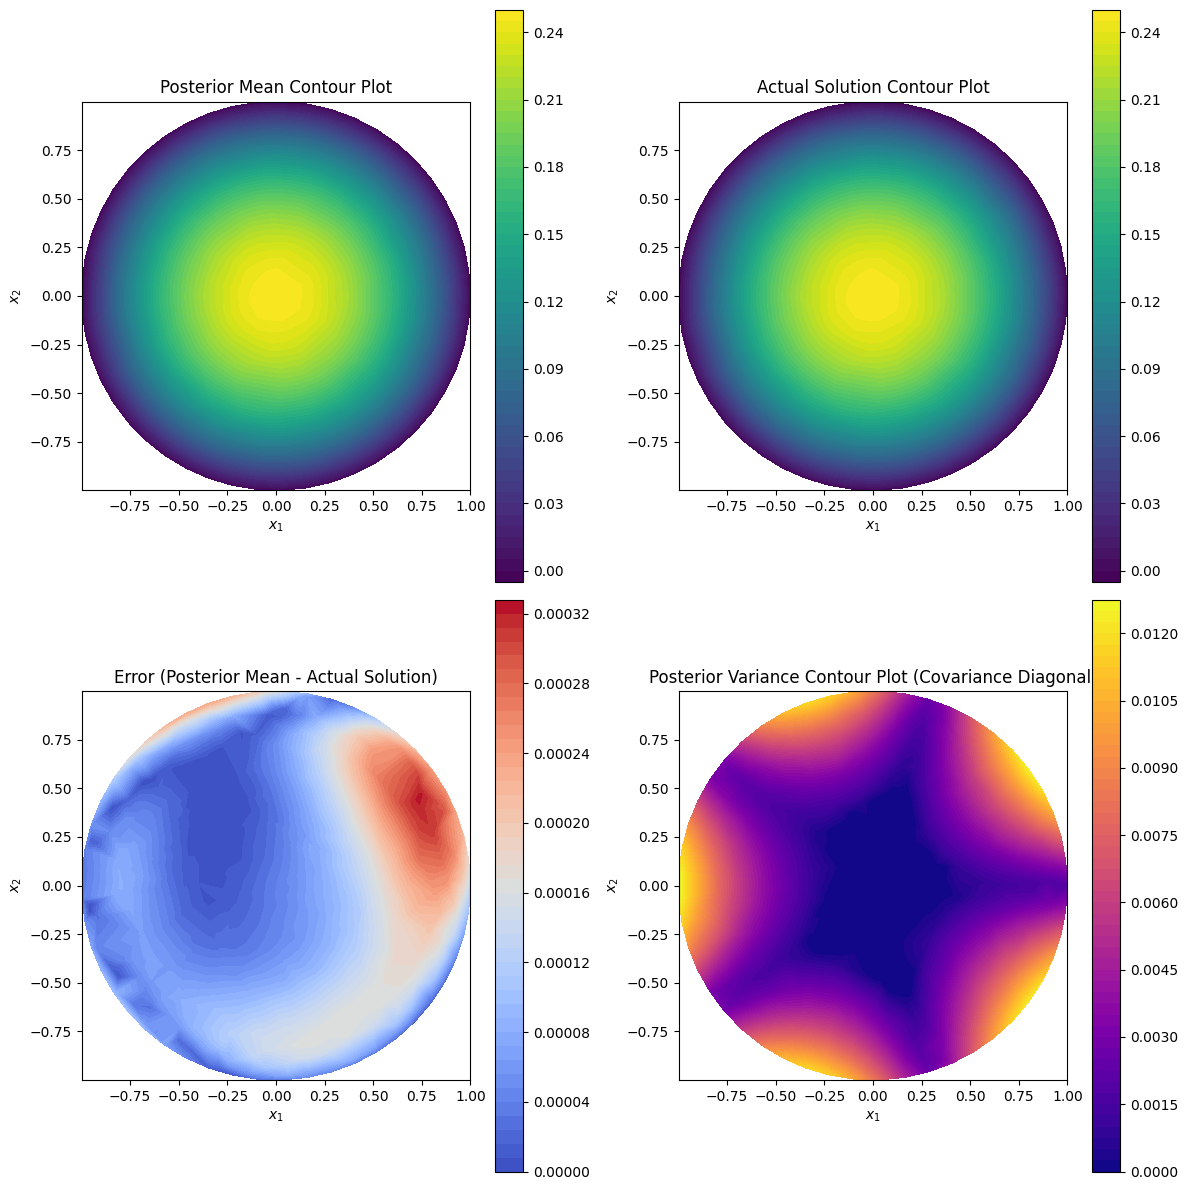


Error Statistics:
Mean absolute error: 0.000095
Max absolute error: 0.000324
RMSE: 0.000122
Relative error: 0.000805


In [60]:
# Check if all required variables are defined and valid
required_vars = ['X_test', 'posterior_mean_sdd', 'posterior_cov_sdd_sqrt']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"Missing variables: {missing_vars}")
    print("Variables not properly initialized. Please run previous cells.")
else:
    # Check for NaN values before plotting
    if torch.isnan(posterior_mean_sdd).any() or torch.isnan(posterior_cov_sdd_sqrt).any():
        print("Warning: NaN values detected, using exact method for plotting")
        posterior_mean_sdd = posterior_mean
        posterior_cov_sdd_sqrt = posterior_cov

    # Detach the tensors from the computation graph if requires_grad=True
    x1 = X_test[:, 0].detach().numpy()  # Extract the x1 (first column)
    x2 = X_test[:, 1].detach().numpy()  # Extract the x2 (second column)
    posterior_mean_np = posterior_mean_sdd.detach().numpy().reshape(-1)  # Flatten the posterior mean
    posterior_cov_np = posterior_cov_sdd_sqrt.detach().numpy().reshape(-1)  # Flatten the posterior covariance

    # Remove NaN and infinite values for plotting
    valid_indices = np.isfinite(posterior_mean_np) & np.isfinite(posterior_cov_np) & np.isfinite(x1) & np.isfinite(x2)
    print(f"Valid data points for plotting: {np.sum(valid_indices)} out of {len(x1)}")

    if np.sum(valid_indices) < 10:
        print("Too few valid points for plotting. Skipping visualization.")
    else:
        x1_valid = x1[valid_indices]
        x2_valid = x2[valid_indices]
        posterior_mean_valid = posterior_mean_np[valid_indices]
        posterior_cov_valid = posterior_cov_np[valid_indices]
        
        # Compute the actual solution u(x1, x2) = (1 - x1^2 - x2^2) / 4
        actual_solution_valid = (1 - x1_valid**2 - x2_valid**2) / 4
        
        # Compute the error between the posterior mean and actual solution
        error_valid = np.abs(posterior_mean_valid - actual_solution_valid)
        
        # Create subplots for posterior mean, actual solution, error, and posterior covariance
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Create 4 subplots
        
        try:
            # Plot the posterior mean using contour plots (like working version)
            contour_posterior = axes[0, 0].tricontourf(x1_valid, x2_valid, posterior_mean_valid, levels=50, cmap='viridis')
            fig.colorbar(contour_posterior, ax=axes[0, 0])
            axes[0, 0].set_title('Posterior Mean Contour Plot')
            axes[0, 0].set_xlabel('$x_1$')
            axes[0, 0].set_ylabel('$x_2$')
            axes[0, 0].set_aspect('equal')  # Equal aspect ratio for circular domain
            
            # Plot the actual solution using contour plots
            contour_actual = axes[0, 1].tricontourf(x1_valid, x2_valid, actual_solution_valid, levels=50, cmap='viridis')
            fig.colorbar(contour_actual, ax=axes[0, 1])
            axes[0, 1].set_title('Actual Solution Contour Plot')
            axes[0, 1].set_xlabel('$x_1$')
            axes[0, 1].set_ylabel('$x_2$')
            axes[0, 1].set_aspect('equal')
            
            # Plot the error using contour plots
            contour_error = axes[1, 0].tricontourf(x1_valid, x2_valid, error_valid, levels=50, cmap='coolwarm')
            fig.colorbar(contour_error, ax=axes[1, 0])
            axes[1, 0].set_title('Error (Posterior Mean - Actual Solution)')
            axes[1, 0].set_xlabel('$x_1$')
            axes[1, 0].set_ylabel('$x_2$')
            axes[1, 0].set_aspect('equal')
            
            # Plot the posterior variance using contour plots (with better scaling)
            contour_variance = axes[1, 1].tricontourf(x1_valid, x2_valid, 2*posterior_cov_valid, levels=50, cmap='plasma')
            fig.colorbar(contour_variance, ax=axes[1, 1])
            axes[1, 1].set_title('Posterior Variance Contour Plot (Covariance Diagonal)')
            axes[1, 1].set_xlabel('$x_1$')
            axes[1, 1].set_ylabel('$x_2$')
            axes[1, 1].set_aspect('equal')
            
            # Adjust layout to prevent overlap
            plt.tight_layout()
            
            # Show plot
            plt.show()
            
            # Print error statistics
            print(f"\nError Statistics:")
            print(f"Mean absolute error: {np.mean(error_valid):.6f}")
            print(f"Max absolute error: {np.max(error_valid):.6f}")
            print(f"RMSE: {np.sqrt(np.mean(error_valid**2)):.6f}")
            print(f"Relative error: {np.mean(error_valid) / np.mean(np.abs(actual_solution_valid)):.6f}")
            
        except Exception as e:
            print(f"Error in contour plotting: {e}")
            print("Data points may be insufficient or have issues for triangulation.")
            print(f"Data range: x1=[{np.min(x1_valid):.3f}, {np.max(x1_valid):.3f}], x2=[{np.min(x2_valid):.3f}, {np.max(x2_valid):.3f}]")